In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
import matplotlib
import numpy
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torchvision import utils

In [2]:
show_image=True
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    inp[inp>1]=1
    inp[inp<-1]=-1
    plt.imshow(inp)
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        print("Don't show")

In [3]:
z_size=128
hidden_size=512
img_size=32
niter=100
epsilon=1

In [4]:
root = './data'
download = True
trans = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = dset.MNIST(
    root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 200
kwargs = {}
D_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)
G_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, img_size**2),
            nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(100,100)
        )

    def forward(self, x):
        x = x.view(x.size(0), img_size * img_size)
        return x

In [7]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if torch.cuda.is_available():
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
mone = one * -1

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
def sinkhorn_loss(x, y, epsilon, n, niter):
    """
	Given two emprical measures with n points each with locations x and y
	outputs an approximation of the OT cost with regularization parameter epsilon
	niter is the max. number of steps in sinkhorn loop
	"""
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)  # Wasserstein cost function

    # both marginals are fixed with equal weights
    if torch.cuda.is_available():
        mu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    else:
        mu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  #(.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) +
                         1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin))**p, 2)
    return c

  0%|          | 0/10000 [00:00<?, ?it/s]

Generator (
  (model): Sequential (
    (0): Linear (128 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 1024)
    (5): Tanh ()
  )
)


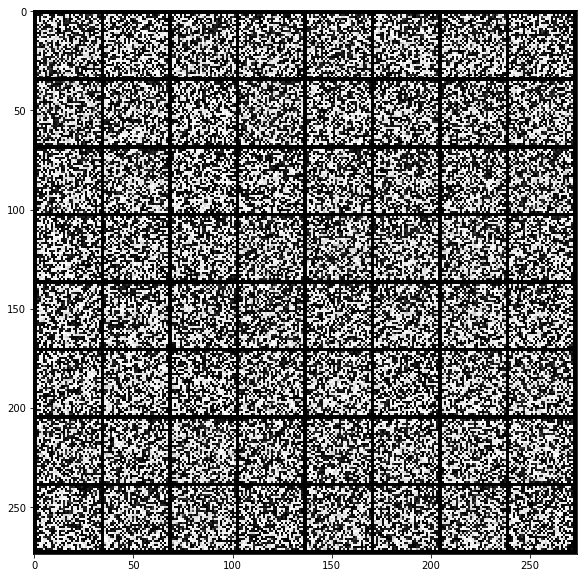

  0%|          | 49/10000 [08:35<29:03:51, 10.51s/it]

In [ ]:
from tqdm import tqdm
G = Generator()
G.apply(weights_init)
D = Discriminator()
print(G)
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-5
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000)):
    optimizers['G'].zero_grad()
    data=next(iter(G_loader))[0]
    input_holder.resize_as_(data).copy_(data)
    y = D(Variable(data))
    noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
    noisev = Variable(noise_holder)
    fake_data = G(noisev)
    x = D(fake_data)
    W_xy=sinkhorn_loss(x,y,epsilon,batch_size,niter)
    W_xx=sinkhorn_loss(x,x,epsilon,batch_size,niter)
    W_yy=sinkhorn_loss(y,y,epsilon,batch_size,niter)
    Loss_G=2*W_xy-W_xx-W_yy
    Loss_G.backward(one)
#     G_loss = -torch.mean(output_fake1)

#     G_loss.backward()
    optimizers['G'].step()

    if epoch % 100 == 0:
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:64])
        else:
            dd = utils.make_grid(fake_data.data[:64])
        imshow(dd,'./results/WGAN_DC_%d.png'%(epoch))
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/OrWGAN_DC_%d.png'%(epoch))